# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.172039,False,-0.324842
1,-0.788148,False,-1.455807
2,1.337097,True,8.413473
3,-1.080333,False,-2.151275
4,0.154272,True,7.157026
...,...,...,...
995,-1.556872,False,-2.870455
996,-2.466739,False,-6.340582
997,-1.168171,False,-2.185424
998,1.531933,True,9.351525


<Axes: xlabel='v0'>

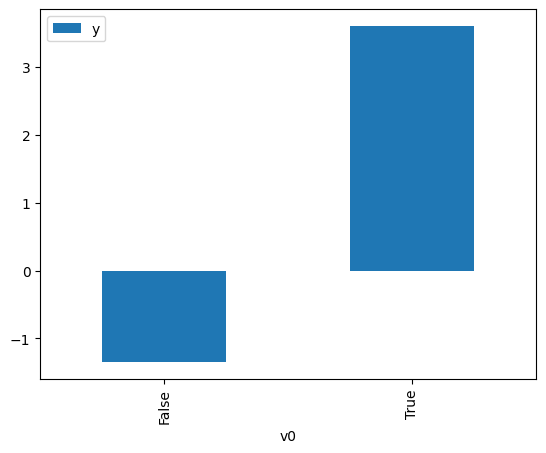

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

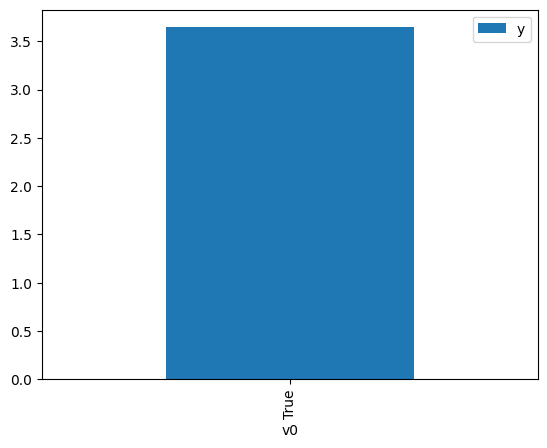

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.223670,False,-1.601517,0.575923,1.736342
1,0.964271,False,3.069759,0.232332,4.304178
2,-0.455364,False,-0.832242,0.645396,1.549437
3,0.779032,False,-0.273321,0.276659,3.614554
4,-0.837801,False,-0.271020,0.746903,1.338862
...,...,...,...,...,...
995,-2.079971,False,-5.226434,0.934131,1.070514
996,-0.541406,False,-0.369385,0.669870,1.492827
997,1.001796,False,3.765739,0.223982,4.464643
998,0.431975,False,0.227247,0.372267,2.686245


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.110835,True,-0.072114,0.193534,5.167042
1,-1.991549,True,0.089370,0.073088,13.682195
2,-0.660857,True,4.490841,0.297642,3.359740
3,-1.803182,True,1.030242,0.090945,10.995674
4,-1.775956,True,0.356981,0.093830,10.657606
...,...,...,...,...,...
995,0.426622,True,7.576351,0.626151,1.597059
996,0.135862,True,4.701648,0.537006,1.862177
997,1.049072,True,7.725489,0.786231,1.271891
998,-0.076694,True,5.171246,0.469956,2.127858


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              9234.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):                        0.00
Time:                        19:14:44   Log-Likelihood:                         -1378.0
No. Observations:                1000   AIC:                                      2760.
Df Residuals:                     998   BIC:                                      2770.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3419      0.026     90.918      0.000       2.291       2.392
x2             5.0164      0.051     98.326      0.000       4.916       5.116
==============================================================================
Omnibus:                        4.083   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                3.989
Skew:                          -0.121   Prob(JB):                        0.136
Kurtosis:                       2.808   Cond. No.                         1.98
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""